In [1]:
import warnings

import pandas as pd
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from ptsa.data.timeseries import TimeSeries
from cmlreaders import CMLReader, get_data_index

In [2]:
import Reader
import ComputePower

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
EXPERIMENT = 'TH1'
EVENTS_TYPE = 'CHEST'
REL_START=-2000
REL_STOP=3500
BUFFER=2000
FREQ_BAND=[1,3]

In [5]:
def error_fill(xs, ys, err, color, label, axes=None):
    
    if axes == None:
        plotter = plt
    else:
        plotter = axes
    
    plotter.fill_between(xs, ys-err, ys+err,
                     alpha=.4, color=color)
    plotter.plot(xs, ys, label=label, color=color)

In [6]:
def get_roi_locs(subjects):

    warnings.filterwarnings('ignore')

    rois = ['Left EC', 'Right EC', 'Left CA1', 'Right CA1']

    roi_locs = {}
    for roi in rois:
        roi_locs[roi] = []

    for i, subject in subjects.iterrows():
        contacts = Reader.load_contacts(**subject)
        for roi in rois:
            if roi in contacts['stein.region'].unique():
                roi_locs[roi].append(True)
            else:
                roi_locs[roi].append(False)

    for roi in rois:
        roi_locs[roi] = np.array(roi_locs[roi])

    return roi_locs

In [7]:
def get_erps_1subj(region,
                   events_type=EVENTS_TYPE, freq_band=FREQ_BAND,
                   rel_start_ms=REL_START, rel_stop_ms=REL_STOP,
                   buf_ms=BUFFER, resample_freq=None,
                   **subject_dict
                  ):
    
    # get events
    events = Reader.get_all_events(**subject_dict)
    events = events[events['type']==events_type]
    events.index = range(len(events))
    
    # get elecs
    all_elecs = Reader.load_contacts(**subject_dict)
    contacts = Reader.get_region_contacts(region, 'stein.region', all_elecs)
    
    # get powers
    eeg = Reader.load_eeg(events, contacts, **subject_dict,
                   rel_start_ms=-2000, rel_stop_ms=3500,
                   do_average_ref=False, pass_band=freq_band,
                   buf_ms=buf_ms, resample_freq=resample_freq,
                  )
    
    powers = ComputePower.compute_power(eeg, buf_ms)
    
    # split by recalled, not recalled, and empty chests
    recalled_locs = events['recalled'].values
    empty_locs = (events['item_name']=='').values
    not_recalled_locs = ~(recalled_locs|empty_locs)
    
    # get powers accross events
    rec_power = powers[recalled_locs].mean(dim='event')
    nrec_power = powers[not_recalled_locs].mean(dim='event')
    empty_power = powers[empty_locs].mean(dim='event')
    
    # get erps accross channels
    rec_erp = rec_power.mean(dim='channel')
    rec_sem = rec_power.std(dim='channel') / np.sqrt(rec_power.channel.size)

    nrec_erp = nrec_power.mean(dim='channel')
    nrec_sem = nrec_power.std(dim='channel') / np.sqrt(nrec_power.channel.size)

    empty_erp = empty_power.mean(dim='channel')
    empty_sem = empty_power.std(dim='channel') / np.sqrt(nrec_power.channel.size)

    # done
    return pd.DataFrame({'rec_erp': rec_erp, 'rec_sem': rec_sem,
                         'nrec_erp': nrec_erp, 'nrec_sem': nrec_sem,
                         'empty_erp': empty_erp, 'empty_sem': empty_sem, 
                         'samplerate': rec_power.samplerate.values[()]
                        })

In [8]:
def plot_erp(erps, freq_band=FREQ_BAND,
             rel_start_ms=REL_START, rel_stop_ms=REL_STOP,
             axes=None):
    
    samplerate = erps['samplerate'].iloc[0]
    
    xs = np.arange(rel_start_ms, rel_stop_ms, 1000./samplerate)
    
    rec_color = 'firebrick'
    nrec_color = 'steelblue'
    empty_color = 'gray'
    
    if axes is None:
        axes = plt.subplot()

    error_fill(xs, erps['rec_erp'], erps['rec_sem'], color=rec_color, label='recalled', axes=axes)
    error_fill(xs, erps['nrec_erp'], erps['nrec_sem'], color=nrec_color, label='not recalled', axes=axes)
    error_fill(xs, erps['empty_erp'], erps['empty_sem'], color=empty_color, label='empty', axes=axes)

    axes.axvline(0, color='k')
    axes.axvline(1500, color='gray', linestyle=':') # item stops being displayed
    axes.axhline(0, color='k', linestyle='--')

    axes.set_xlabel('time (ms)')
    axes.set_ylabel(fr'Z(power) $\emdash$ [{freq_band[0]}-{freq_band[1]}] Hz')

    axes.legend()

In [14]:
def get_erps(subjects, region, freq_band,
             graphit=True, resample_freq=500):

    if graphit:
        # set up graph on 1 subplot per subj
        ncols = int(np.sqrt(len(subjects)))
        nrows = int(np.ceil(len(subjects)/ncols))
        fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,15))
        fig.tight_layout()

    # store each subjects erps in these lists
    all_recs = []
    all_nrecs = []
    all_emptys = []
    subjects_with_data = []

    # get each subject's erp
    for i, subject in tqdm(subjects.iterrows(), total=len(subjects)):

        try:
            erps = get_erps_1subj(
                **subject, region=region,
                freq_band=freq_band,
                resample_freq=resample_freq
            )

            all_recs.append(erps['rec_erp'])
            all_nrecs.append(erps['nrec_erp'])
            all_emptys.append(erps['empty_erp'])
            subjects_with_data.append(
                Reader.subject_id(subject['subject'], subject['montage']))

            if graphit:
                plot_erp(erps, axes=axes[i%nrows, int(i/nrows)])
        except (IndexError, ValueError):
            continue
            
    if graphit:
        plt.show()
    
    # concatenate erps accross subjects 
    recs = pd.concat(all_recs, axis=1)
    recs = xr.DataArray(recs.values.transpose(),
                        coords=[subjects_with_data, recs.index],
                        dims = ['subject', 'time'])

    nrecs = pd.concat(all_nrecs, axis=1)
    nrecs = xr.DataArray(nrecs.values.transpose(),
                        coords=[subjects_with_data, nrecs.index],
                        dims = ['subject', 'time'])

    emptys = pd.concat(all_emptys, axis=1)
    emptys = xr.DataArray(emptys.values.transpose(),
                        coords=[subjects_with_data, emptys.index],
                        dims = ['subject', 'time'])
    
    # get erps accross subjects
    rec_erp = recs.mean(dim='subject')
    rec_sem = recs.std(dim='subject') / np.sqrt(recs.subject.size)

    nrec_erp = nrecs.mean(dim='subject')
    nrec_sem = nrecs.std(dim='subject') / np.sqrt(nrecs.subject.size)

    empty_erp = emptys.mean(dim='subject')
    empty_sem = emptys.std(dim='subject') / np.sqrt(emptys.subject.size)
    

    # done
    return pd.DataFrame({'rec_erp': rec_erp, 'rec_sem': rec_sem,
                         'nrec_erp': nrec_erp, 'nrec_sem': nrec_sem,
                         'empty_erp': empty_erp, 'empty_sem': empty_sem, 
                         'samplerate': resample_freq
                        })

In [15]:
region='Right CA1'

In [16]:
df = get_data_index('r1')
df = df[df['experiment']==EXPERIMENT]
subjects = df[['subject', 'montage', 'localization', 'experiment']].drop_duplicates()
subjects.index = range(len(subjects))

In [17]:
roi_locs = get_roi_locs(subjects)
roi_subjects = subjects[roi_locs[region]]
roi_subjects.index = range(len(roi_subjects))

In [ ]:
erps = get_erps(roi_subjects, region=region, freq_band=[1,3])
plot_erp(erps)

In [ ]:
erps = get_erps(subjects, region='Left CA1', freq_band=[1,3])
plot_erp(erps)

KeyboardInterrupt: 

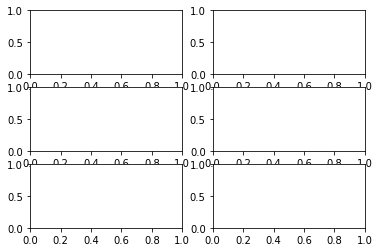

In [20]:
regions = ['Left CA1', 'Right CA1']
freq_bands = [[1,3], [3,10], [40,100]]

fig, axes = plt.subplots(nrows=len(freq_bands), ncols=len(regions))

for col, region in enumerate(regions):
    for row, freq_band in enumerate(freq_bands):
        ax = axes[col, row]
        
        erps = get_erps(subjects, region=region, freq_band=freq_band, graphit=False)
        plot_erp(erps, axes=ax)
        
        if row == 0:
            ax.title(region)